# Framework for Evaluating Player's Pass Selection
Below is the coding framework for how someone could evaluate players in the 2018 world cup on their pass selection. pass selection will be evaluated by using the expected completion percentage(xCompletion%) based off their pass selection. This framework is extremely limited but a good starting point for the subject.

The framework has three main steps.
1. configure a player database that for every game in the world cup a player played has the number of passes they made and the average xCompletion% on those passes 
2. Regress every player towards the mean so that sample size(number of passes attempted) can be taken into account
3. Reconfigure the player databse to have gp and regressed xCompletion% as attributes and rank them on their xCompletion%
       
     
The machine learning model is based off of Devin Pleuler's repository applied-examples and the code can be found at the link below:
https://github.com/devinpleuler/applied-examples/blob/master/Estimating%20Pass%20Difficulty.ipynb

the model was done to estimate pass difficulty but it can double as the probability of a completion and thus a player who makes passes with higher completion probability could be considered to have a higher passing iq. The one difference between his model and mine is that Devin used Logistic Regression and I used a Multi-Layer Perceptron (MLP Classifier). the advantage of the MLP Classifier in my opinion is that it can be more fluid and makes connections between the data passed to it easier than Logistic Regression does. 


DEPENDENCIES:
- pandas
- numpy
- matplotlib
- sklearn


DISCLAIMER:

- The one issue with using a MLP Classifier is that it requires a lot of training data and we may not have enough tp get accurate results. 

- In this model we'll be evaluating passes from the 2018 world cup, the same passes we   trained the model with which is bad practice; however, we dont have enough data do another way.
 
- the method for regressing to the mean is not perfect a better way to do it would be to find correlation between games - make one list of even games another list of odd games and correlate the two - but many players play 3 games or only 2 games so the method would not work

- Due to how the players are ranked, players who are more risk-averse will be ranked better than other players. We as humans can understand that sometimes riskier plays can be better for your team than playing it safe. Model's that take into account the value gained from the pass would be much more complex. For such models I recomend people read Luke Bornn's paper on space creation

for these reasons I've named this as a framework for how to measure something like pass iq so other people can learn from or apply it to other scenarios. The results shown should not be used for any statistical evaluation of players.



IF YOURE DOING THIS ON YOUR MACHINE THEN GO INTO 'passes.csv' AND DELETE THE FIRST COMMA AT THE TOP UNLESS YOULL KEEP GETTING KEYERROR MESSAGES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import sklearn
import requests
%matplotlib inline

In [2]:
#import pre-made csv of all players in world cup and make it into a dict
players = pd.read_csv('player.csv').transpose().to_dict()

#import ML model, refer to david pleuler post for model information
filename = 'passes_ML.sav'
model = pickle.load(open(filename,'rb'))


In [3]:
player = pd.read_csv('player.csv')
player.head()

,Games,Name,Team
3531,{},Mohamed Salah,Egypt
3536,{},Ramadan Sobhi,Egypt
3568,{},Mohamed Naser Elsayed Elneny,Egypt
4063,{},Ahmed Hegazi,Egypt
5250,{},Ahmed Fathy Abdel Meneim Ibrahim,Egypt


In [4]:
#open up matches info and make a list of all the match ids
tournament = requests.get('https://raw.githubusercontent.com/statsbomb/open-data/master/data/matches/43.json').json()

match_ids = []
for g in tournament:
    m_id = g['match_id']
    match_ids.append(m_id)


In [5]:

path = 'https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{}.json'
one = True
for id in match_ids:
    #get all the passes in the match
    passes = requests.get(path.format(id)).json()
    passes = [x for x in passes if x['type']['name'] == "Pass" and x['position']['name'] != 'Goalkeeper']
    
    #feed model pass info on passes to get probability of a completion
    for play in passes:
        player_id = play['player']['id']
        #feeds pass vairables to model to get expected completion% ('x','y','length','angle')
        features = play['location'][0], play['location'][1],play['pass']['length'],play['pass']['angle']
        features = np.array(features)
        chance = float(model.predict_proba(features.reshape(1,-1))[0].tolist()[1])
    
        #sets player position, will be used later
        players[player_id]['Position'] = play['position']['name']
    #try is used to see if there are any keys in the model, if there are none an exception occurs
    #and then the except handles the player as a new player
        try:
            #check if game already exists for player
            if id in players[player_id]['Games'].keys():
                #if so add 1 to passes and recalculate the pass completion average
                players[player_id]['Games'][id]['passes'] = players[player_id]['Games'][id]['passes'] + 1
                players[player_id]['Games'][id]['xP_av'] = (players[player_id]['Games'][id]['xP_av'] * (players[player_id]['Games'][id]['passes'] -1) + chance) / players[player_id]['Games'][id]['passes']
            
            else:
                #if player has not had game set up a new dictionary for that game indexed by the match id
                players[player_id]['Games'][id] = {
                    'passes': 1,
                    'xP_av' : chance,
                }
        except:
            #create the games part od the dictionary into a dictionary for every game
            players[player_id]['Games'] = {}
            players[player_id]['Games'][id] = {}
            players[player_id]['Games'][id]['passes'] = 1
            players[player_id]['Games'][id]['xP_av'] = chance
        
            

In [6]:
#pops players who have no xpass data from the main dict
to_pop = []
for player in players:    
    games = players[player]['Games']
    if len(games) > 1:
        xp1 = []
        for game in games:
            if game == '{':
                to_pop.append(player)

for names in to_pop:
    players.pop(names)

In [7]:
xp = {}

#creates a dict of every player indexed by player id and the values are expected completion
#average and total passes made
tot_passes = []
passcomp = []
for player in players:    
    games = players[player]['Games']
  
    xp1 = []
    passes = []
    for game in games:

        xp1.append(games[int(game)]['xP_av'])
        passes.append(games[int(game)]['passes'])

    xp[player] = np.mean(xp1), np.sum(passes) 
    tot_passes.append(np.sum(passes))
    passcomp.append(np.mean(xp1))

# Regressing xCompletion%

In [8]:
'''
below is the basic formula for regressing to the mean, its based off a method described in 
the book 'stat shot, fans guide' by Rob Vollman
reg_val = (expected_completion_average * number_of_passes + (threshold - number_of_passes) * av_expected_completion_aveage) / threshold
'''
#collecting the threshold as a value of 30 over the max, the bigger the addition the 
#stronger players get regressed to the mean
thresh = np.max(tot_passes) + 30
print(thresh)

#find the average xcompletion across all players
xp_all = []
for people in xp:
    xp_all.append(xp[people][0])

av_prec = np.mean(xp_all)
print(av_prec)

557
0.8391646161522741


In [9]:
#applied the formula to each player in db and make a dictionary(playerid : regressed value)
reg_val = {}
for passers in xp:
    passes = xp[passers][1]
    xcomp = xp[passers][0]
    to_add = thresh - passes
    new_val = (((passes/thresh) * xcomp) + ((to_add/thresh) * av_prec))
    reg_val[passers] = new_val

    

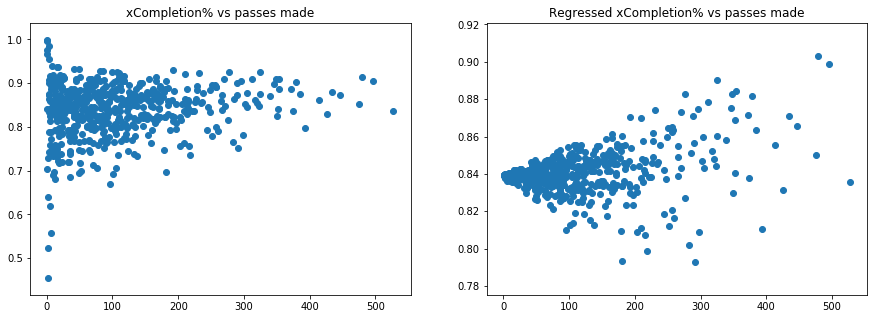

In [10]:
#plot xcompletion% with passes
#in the first graph their are people with high pass% but nearly no shots so we cant say they are truly 95% passers
#so we have to assumer they are only slightly above average; however, the people with 400+ shots that are 90% passers
#have more accurate numbers because they have consistently made high percentage passes so they dont regress as much
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(121)
ax.scatter(tot_passes,passcomp )
ax.set_title('xCompletion% vs passes made')

ax = fig.add_subplot(122)
plt.scatter(tot_passes, reg_val.values())
ax.set_title('Regressed xCompletion% vs passes made')
plt.show()

# Re-create the player databse with GP and xCompletion%

In [11]:
# add regressed xCompletion and games played to the old player dictionary
for player in players:
    players[player]['Games'] = len(players[player]['Games'])
    players[player]['xCompletion%'] = round((reg_val[player] * 100), 2)


In [12]:
#new player info
print(players[5556])

{'Games': 4, 'Name': 'Miguel Arturo Layún Prado', 'Team': 'Mexico', 'Position': 'Right Back', 'xCompletion%': 82.74}


In [13]:
players = pd.DataFrame(players).transpose()

In [14]:
players = players.sort_values(by='xCompletion%', ascending=False)
players.head()

,Games,Name,Position,Team,xCompletion%
3244,7,John Stones,Center Back,England,90.31
5201,4,Sergio Ramos García,Left Center Back,Spain,89.87
5642,6,Axel Witsel,Left Center Midfield,Belgium,89.01
5213,4,Gerard Piqué Bernabéu,Right Center Back,Spain,88.43
5506,4,Javier Alejandro Mascherano,Right Center Midfield,Argentina,88.26
